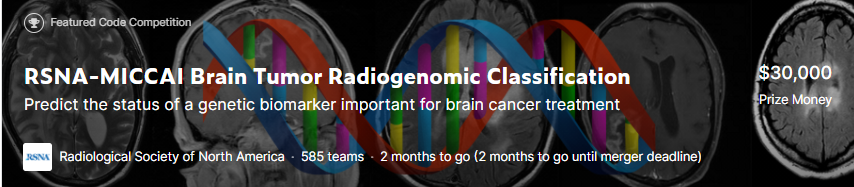

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Import</span>

In [ ]:
!conda install '../input/gdcm-file/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -y --offline
!conda install '../input/gdcm-file//libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -y --offline
!conda install '../input/gdcm-file//gdcm-2.8.9-py37h500ead1_1.tar.bz2' -y --offline
!conda install '../input/gdcm-file//conda-4.10.1-py37h89c1867_0.tar.bz2' -y --offline
!conda install '../input/gdcm-file//certifi-2020.12.5-py37h89c1867_1.tar.bz2' -y --offline
!conda install '../input/gdcm-file//openssl-1.1.1k-h7f98852_0.tar.bz2' -y --offline

In [ ]:
!pip install timm

In [ ]:
import torch

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import glob
import scipy as sp
import numpy as np
import pandas as pd

import librosa
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial
import tensorflow as tf
import cv2
from PIL import Image
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import matplotlib.pyplot as plt
from torch.utils import data as torch_data
import timm

from torch.cuda.amp import autocast, GradScaler
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
timm.list_models()

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Load</span>

In [ ]:
train = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
train['BraTS21ID'] =train['BraTS21ID'].apply(lambda x: str(x).zfill(5))
test = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
test['BraTS21ID'] =test['BraTS21ID'].apply(lambda x: str(x).zfill(5))
def get_train_file_path(image_id):
    return "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{}".format(image_id)

def get_test_file_path(image_id):
    return "../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{}".format(image_id)

train['file_path'] = train['BraTS21ID'].apply(get_train_file_path)
test['file_path'] = test['BraTS21ID'].apply(get_test_file_path)

print(len(train))
display(train.head())
display(test.head())

In [ ]:
train.loc[0,'file_path']

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Functions</span>

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

#seed_torch(seed=CFG.seed)
    

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Settings</span>

In [ ]:
class CFG:
    sliced =0
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    #odel_name='nfnet_l0'
    
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=3#3
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=8 #64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='MGMT_value'
    n_fold=2 #5
    trn_fold=[0, 1]  #, 2, 3, 4]
    train=True
    mai =8
    col ='FLAIR' #'T1w,T1wCE,T2w'
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=5000, random_state=CFG.seed).reset_index(drop=True)
    
cfg = CFG()

mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64 #64

data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'


In [ ]:
train['fold'] = range(len(train))
train['fold'] = train['fold'].apply(lambda x: x%5)
    
train.to_csv('study_train_df.csv')
train.head(6)




In [ ]:
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    #print(p1,p2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Dataset</span>

In [ ]:
# ====================================================
# Dataset
# ====================================================
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
        

    def __getitem__(self, index):
        
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type, split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type, split="train", rotate=rotation)

        if self.targets is None:
            return torch.tensor(data).float(), scan_id
        else:
            y = torch.tensor(self.targets[index], dtype=torch.float)
            return torch.tensor(data).float(), y

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Model</span>

In [ ]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        chan=1
        if model_name.split('_')[0][:9]  =='seresnext':
            self.model = timm.create_model(model_name ,pretrained=pretrained, in_chans=chan)
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.n_features, self.cfg.target_size)

        if model_name.split('_')[0] =='efficientnet':
            self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=chan)
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)

        if model_name.split('_')[0] =='tf':
            self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=chan)
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)

        
        if model_name.split('_')[0] =='nfnet':   
            self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=chan)
            self.n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(self.n_features, self.cfg.target_size)
            
        if model_name.split('_')[0] =='vit':
            self.model = timm.create_model(model_name, pretrained=pretrained)
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, CFG.target_size)

        
    def forward(self, x):
        output = self.model(x)
        return output

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Functions</span>

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:

    model_name='seresnet152'
    folds = train
    fold =0
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    train_dataset = Dataset(train_folds.BraTS21ID,targets=train_folds.MGMT_value,mri_type='FLAIR') #, transform=get_transforms(data='train'))
    valid_dataset = Dataset(valid_folds.BraTS21ID,targets=valid_folds.MGMT_value,mri_type='FLAIR') #, transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in tqdm(enumerate(train_loader)):
        print('step',step)
        break
    
      

In [ ]:
images.shape

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in tqdm(enumerate(train_loader)):
      images = np.array(images)
      images = images.transpose(4,0,1,2,3)
      #print(images.shape)
      images = torch.tensor(images)
      for i in range(images.shape[0]):
       #for x in range(images.shape[1]):
       #for x in range(images.shape[1]):
        #print(images.shape[4])
        data_time.update(time.time() - end)
        image = torch.tensor(images[i])
        #print('#',image.shape)
        #image = torch.tensor(image[:,:,:,np.newaxis])
        image = image.to(device)
        label = torch.tensor(labels[step//NUM_IMAGES])
        label = label.to(device)
        batch_size = cfg.batch_size
        if CFG.apex:
            with autocast():
                y_preds = model(image)
                loss = criterion(y_preds.view(-1), label)
        else:
            y_preds = model(image)
            #print('@@@@',y_preds,y_preds.view(-1)[0],label)
            loss = criterion(y_preds.view(-1)[0], label)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i==(images.shape[0]-1):# and i==(images.shape[0]-1):
        #if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))  
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds_sum=[]
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
      
      preds = []
      images = np.array(images)
      images = images.transpose(4,0,1,2,3)
      images = torch.tensor(images)
      #print(images.shape)
      for i in range(images.shape[0]):
       #for x in range(images.shape[1]):
        #print(images.shape[4])
        data_time.update(time.time() - end)
        image = torch.tensor(images[i])
        #image = torch.tensor(image[:,:,:,np.newaxis])
        image = image.to(device)
        label = torch.tensor(labels)
        label = label.to(device)
        batch_size = cfg.batch_size
        # compute loss
        with torch.no_grad():
            y_preds = model(image)
        #print('@@@@',y_preds,y_preds.view(-1)[0],label,label[0])
        loss = criterion(y_preds.view(-1), label)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i==(images.shape[0]-1):
        #if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
       #print(step,i,images.shape[0])
        if i %(images.shape[0]-1)==0 and i!=0:
           preds_sum.append(np.mean(preds)) #ここで64枚の予測平均の算出が必要   
           #print('##',step,' ',i,' ',len(preds_sum))
    predictions = preds_sum
    return losses.avg, predictions

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Training</span>

### Debug

In [ ]:
    '''
    #def train_loop(folds, fold,mri):
    folds=train
    fold =0
    model_name='tf_efficientnetv2_m'
    mri='FLAIR'
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = Dataset(train_folds.BraTS21ID,targets=train_folds.MGMT_value,mri_type=mri)
    valid_dataset = Dataset(valid_folds.BraTS21ID,targets=valid_folds.MGMT_value,mri_type=mri)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=1, #CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
       # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        print(valid_labels, preds)
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
'''

In [ ]:
def train_loop(folds, fold,mri):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = Dataset(train_folds.BraTS21ID,targets=train_folds.MGMT_value,mri_type=mri)
    valid_dataset = Dataset(valid_folds.BraTS21ID,targets=valid_folds.MGMT_value,mri_type=mri)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=1, #CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
       # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            #scheduler.step(avg_val_loss)
            continue
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        #print(valid_labels, preds)
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{model_name}_fold{fold}_{mri}_best_score.pth')
        
        #if avg_val_loss < best_loss:
        #    best_loss = avg_val_loss
        #    LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        #    torch.save({'model': model.state_dict(), 
        #                'preds': preds},
        #                OUTPUT_DIR+f'{model_name}_fold{fold}_{mri}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{model_name}_fold{fold}_{mri}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold,mri)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__':
    model_name='seresnet152'
    mri='FLAIR'
    #main()
    
    mri='T1w'
    #main()
    
    mri='T1wCE'
    main()
    
    mri='T2w'
    #main()

😺😅㊙🔰🗑⬛🟥🟨🟩